In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from datasets import DatasetDict
from datasets import DatasetDict, Dataset, Features, ClassLabel, Value, Array3D
from transformers import Trainer, TrainingArguments, AutoModelForImageClassification, AutoFeatureExtractor
import numpy as np
import os

/home/eh_abdol/.conda/envs/vim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Function to get all image files from a directory


def get_image_files(folder):
    files = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(os.path.join(root, filename))
    return files

# Custom Dataset Class for Binary Classification


class CustomBinaryDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.data = []
        self.class_names = ['Full', 'Partial']  # Explicitly define class names
        self.load_images()

    def load_images(self):
        for class_name in self.class_names:
            class_folder = os.path.join(self.folder, class_name)
            if os.path.isdir(class_folder):
                class_index = self.class_names.index(
                    class_name)  # 0 for 'Full', 1 for 'Partial'
                image_files = get_image_files(class_folder)
                for image_file in image_files:
                    self.data.append({
                        'image': image_file,
                        'label': class_index,  # Binary label: 0 for 'Full', 1 for 'Partial'
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image']
        label = self.data[idx]['label']

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


# Image transformations (Resizing and Normalizing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Folders
train_folder = '/home/eh_abdol/fine_tune/gold/train'
validation_folder = '/home/eh_abdol/fine_tune/gold/validation'
test_folder = '/home/eh_abdol/fine_tune/gold/test'

# Create Datasets
train_dataset = CustomBinaryDataset(train_folder, transform=transform)
validation_dataset = CustomBinaryDataset(
    validation_folder, transform=transform)
test_dataset = CustomBinaryDataset(test_folder, transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(
    validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Now you can use test_loader to evaluate the model after fine-tuning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Dataset size: 362
Validation Dataset size: 63
Test Dataset size: 64


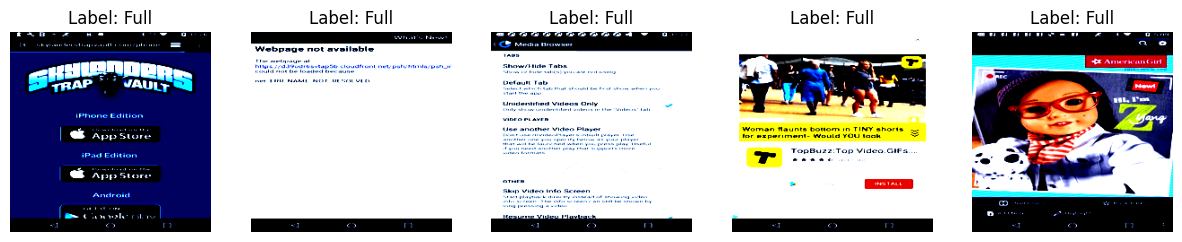

Batch size: 16
Image shape: torch.Size([16, 3, 224, 224])
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1])


In [6]:
import matplotlib.pyplot as plt
import torch

# Function to display a few sample images with labels


def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        image, label = dataset[i]
        # Rearrange dimensions to HWC for plotting
        image = image.permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {dataset.class_names[label]}")
        axes[i].axis('off')
    plt.show()


# Print dataset lengths to ensure the size is correct
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(validation_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

# Visualize a few samples from the training dataset
show_samples(train_dataset, num_samples=5)

# Check DataLoader output
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.size()}")
    print(f"Labels: {labels}")
    break  # Check the first batch only

In [ ]:
# Initialize the model (make sure the architecture is defined and matches the loaded model)
model = VisionMamba(
    patch_size=16,
    stride=8,
    embed_dim=384,
    depth=24,
    rms_norm=True,
    residual_in_fp32=True,
    fused_add_norm=True,
    final_pool_type='mean',
    if_abs_pos_embed=True,
    if_rope=False,
    if_rope_residual=False,
    bimamba_type="v2",
    if_cls_token=True,
    if_devide_out=True,
    use_middle_cls_token=True,
    num_classes=1000,  # Original number of classes
    drop_rate=0.0,
    drop_path_rate=0.1,
    drop_block_rate=None,
    img_size=224,
)

# Modify the head for binary classification
model.head = nn.Linear(in_features=384, out_features=2)

# Load the pretrained model weights
checkpoint = torch.load("path/to/your/checkpoint.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])

# Set model to training mode
model.train()

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fine-tuning loop
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_vision_mamba.pth")

# Set model to evaluation mode
model.eval()

In [ ]:
# Example: Making a prediction
with torch.no_grad():
    test_image = Image.open("path/to/test/image.jpg").convert("RGB")
    test_image = transform(test_image).unsqueeze(0).to(device)
    prediction = model(test_image)
    predicted_class = torch.argmax(prediction, dim=1).item()
    print(f"Predicted class: {predicted_class}")